In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import numpy as np
from torch.utils.data import Dataset, DataLoader, sampler
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision import transforms
from torchvision.transforms import functional as vision_F
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = False

## 1. Loading Dataset ##

### 1.1 Dataset loader ###

In [38]:
import os
from PIL import Image, ImageChops
import numpy as np
import random

class TrainingNucleiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self._root_dir = root_dir
        self.load_train_images_path()
        self._transform = transform
        
    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, idx):
        image_path = self._images[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        final_mask = Image.new('RGB', image.size, (0, 0, 0))
        for mask_path in self._masks[image_path]:
            mask = Image.open(mask_path)
            #mask = ImageChops.add(mask, final_mask)
            final_mask.paste(mask, (0,0), mask)
        final_mask = final_mask.convert('L')
        if self._transform is not None:
            image, final_mask = self._transform([image, final_mask])
        
        return image, final_mask
    
    def load_train_images_path(self):
        self._masks = {}
        for image_name in os.listdir(self._root_dir):
            masks_path = os.path.join(self._root_dir, image_name, 'masks') 
            masks = [os.path.join(masks_path, mask_name)
                     for mask_name in os.listdir(masks_path)
                     if mask_name.endswith('.png')]
            image_path = os.path.join(self._root_dir, image_name, 'images', image_name) + '.png'
            if not os.path.exists(image_path):
                raise Exception("invalid root folder")
            self._masks[image_path] = masks
        self._images = list(self._masks.keys())

### 1.2 Data Augmentation Utils ###

In [39]:
class PairTransform:
    def __init__(self, *transforms):
        self._transforms = transforms
    
    def __call__(self, ims):
        if len(self._transforms) != len(ims):
            raise Exception("Expected the same number of transformation than images")
        return [ t(im) if t is not None else im for t, im in zip(self._transforms, ims) ]

In [40]:
class PairRandomRotation(transforms.RandomRotation):
    def __call__(self, ims):
        
        angle = self.get_params(self.degrees)
        return [vision_F.rotate(im, angle, self.resample, self.expand, self.center) for im in ims]

In [41]:
class PairRandomCrop(transforms.RandomCrop):
    def __call__(self, ims):
        if self.padding > 0:
            img = F.pad(img, self.padding)

        return [vision_F.crop(im, *self.get_params(im, self.size)) for im in ims]

In [46]:
ds = TrainingNucleiDataset('data/stage_1/train/')

In [48]:
ROWS = 2
COLS = 4

images_indices = np.random.randint(len(ds), size=COLS)
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(ROWS, COLS),
                 axes_pad=0.2,
                 )

for i, idx in enumerate(np.nditer(images_indices)):
    im, target = ds[idx]
    grid[i].imshow(im)
    grid[i + COLS].imshow(target)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

In [49]:
ds = TrainingNucleiDataset('data/stage_1/train', transform=transforms.Compose([PairRandomCrop(size=256),
                                                                 PairRandomRotation(degrees=90),
                                                                 #PairTransform(None, transforms.Resize([98, 98])),
                                                                 PairTransform(transforms.ToTensor(), transforms.ToTensor()),
                                                                 PairTransform(None, transforms.Lambda(lambda x: x[0].unsqueeze(0))),
                                                                 ]))

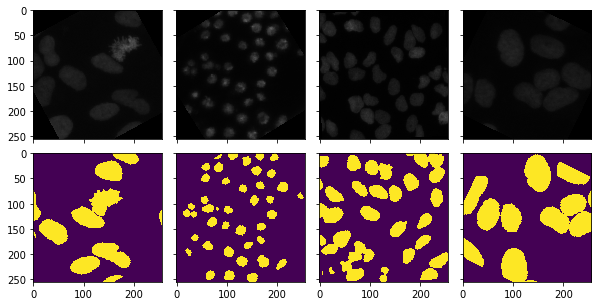

In [45]:
ROWS = 2
COLS = 4

fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(ROWS, COLS),
                 axes_pad=0.2,
                 )

for i, idx in enumerate(np.nditer(images_indices)):
    im, target = ds[idx]
    #print(target.shape)
    grid[i].imshow(im.permute(1,2,0).numpy())
    grid[i + COLS].imshow(target[0].numpy())
plt.show()

In [11]:
ds = TrainingNucleiDataset('data/stage_1/train', transform=transforms.Compose([PairRandomCrop(size=256),
                                                                 PairRandomRotation(degrees=90),
                                                                 PairTransform(None, transforms.Resize([98, 98])),
                                                                 PairTransform(transforms.ToTensor(), transforms.ToTensor()),
                                                                 PairTransform(None, transforms.Lambda(lambda x: x[0].unsqueeze(0)))]))

### 1.3 DataLoaders ###

#### 1.3.1 Splitting into Training and Validation ####

In [12]:
TRAIN_SIZE = int(len(ds) * 0.8)

indices = np.random.permutation(len(ds))
training_indices = indices[:TRAIN_SIZE]
test_indices = indices[TRAIN_SIZE:]

In [13]:
training_sampler = sampler.SubsetRandomSampler(training_indices)

In [14]:
test_sampler = sampler.SubsetRandomSampler(test_indices)

In [15]:
training_dataloader = DataLoader(ds, sampler=training_sampler, batch_size=8, num_workers=2)
test_dataloader = DataLoader(ds, sampler=test_sampler, batch_size=8, num_workers=2)

## Defining the model ##

In [16]:
from torch.nn import functional as F

In [17]:
def center_crop(x, height, width):
    crop_h = torch.FloatTensor([x.size()[2]]).sub(height).div(-2)
    crop_w = torch.FloatTensor([x.size()[3]]).sub(width).div(-2)

    return F.pad(x, [
        crop_w.ceil().int()[0], crop_w.floor().int()[0],
        crop_h.ceil().int()[0], crop_h.floor().int()[0],
    ])

In [18]:
class Conv3Block(nn.Module):
    def __init__(self, channels):
        super(Conv3Block, self).__init__()
        self._layers = nn.Sequential(nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=3, stride=1, padding=0),
                                     nn.ReLU(),
                                     nn.BatchNorm2d(channels[1]),
                                     nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=3, stride=1, padding=0),
                                     nn.ReLU(),
                                     nn.BatchNorm2d(channels[2]),
                                     )
    
    def forward(self, x):
        return self._layers(x)



class Unet(nn.Module):
    def __init__(self, cs=64):
        super(Unet, self).__init__()
        self._convl1block = Conv3Block([3, cs, cs])
        self._pool1 = nn.MaxPool2d(2)
        
        self._convl2block = Conv3Block([cs, 2*cs, 2*cs])
        self._pool2 = nn.MaxPool2d(2)
        
        self._convl3block = Conv3Block([2*cs, 4*cs, 4*cs])
        self._pool3 = nn.MaxPool2d(2)
        
        self._convl4block = Conv3Block([4*cs, 8*cs, 8*cs])
        self._pool4 = nn.MaxPool2d(2)
        
        
        self._convr1block = Conv3Block([8*cs, 16*cs, 16*cs])
        
        
        self._deconv1 = nn.ConvTranspose2d(in_channels=16*cs, out_channels=8*cs, stride=2, kernel_size=4, padding=0)
        self._convr2block = Conv3Block([16*cs, 8*cs, 8*cs])
        
        self._deconv2 = nn.ConvTranspose2d(in_channels=8*cs, out_channels=4*cs, stride=2, kernel_size=4, padding=0)
        self._convr3block = Conv3Block([8*cs, 4*cs, 4*cs])
        
        self._deconv3 = nn.ConvTranspose2d(in_channels=4*cs, out_channels=2*cs, stride=2, kernel_size=4, padding=0)
        self._convr4block = Conv3Block([4*cs, 2*cs, 2*cs])
        
        self._deconv4 = nn.ConvTranspose2d(in_channels=2*cs, out_channels=cs, stride=2, kernel_size=4, padding=0)
        self._convr5block = Conv3Block([2*cs, cs, cs])
        #self._deconv5 = nn.ConvTranspose2d(in_channels=4, out_channels=4, stride=3, kernel_size=2, padding=0)
        self._conv1x1 = nn.Sequential(nn.Conv2d(in_channels=cs, out_channels=1, stride=1, kernel_size=1, padding=0))
        
        
    def forward(self, x):
        x1 = self._convl1block(x)
        t = self._pool1(x1)
        x2 = self._convl2block(t)
        t = self._pool2(x2)
        x3 = self._convl3block(t)
        t = self._pool3(x3)
        x4 = self._convl4block(t)
        t = self._pool4(x4)
        t = self._convr1block(t)
        t = self._deconv1(t)
        x4 = center_crop(x4, t.shape[2], t.shape[3])
        t = torch.cat([x4,t], dim=1)
        t = self._convr2block(t)
        t = self._deconv2(t)
        x3 = center_crop(x3, t.shape[2], t.shape[3])
        t = torch.cat([x3,t], dim=1)
        t = self._convr3block(t)
        t = self._deconv3(t)
        x2 = center_crop(x2, t.shape[2], t.shape[3])
        t = torch.cat([x2,t], dim=1)
        t = self._convr4block(t)
        t = self._deconv4(t)
        x1 = center_crop(x1, t.shape[2], t.shape[3])
        t = torch.cat([x1,t], dim=1)
        t = self._convr5block(t)
        t = self._conv1x1(t)
        return t

In [19]:
unet = Unet(cs=8)

In [20]:
unet

Unet(
  (_convl1block): Conv3Block(
    (_layers): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (_pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (_convl2block): Conv3Block(
    (_layers): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (_pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (_convl3block): Conv3Block(
    (_layers): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride

In [21]:
im, target = next(iter(training_dataloader))
output = unet(Variable(im)).data

In [22]:
output.shape

torch.Size([8, 1, 98, 98])

target.shape

im.shape

unet(Variable(im.cuda()))

In [23]:
from collections import defaultdict

In [24]:
import time
class Trainer(object):
    def __init__(self, model, optimizer, criterion, logging_frecuency=200):
        self._model = model
        self._optimizer = optimizer
        self._log_frec = logging_frecuency
        self._criterion = criterion
        self._history = defaultdict(list)

    def history(self, name):
        return self._history[name]

    def _log(self, i):
        total_steps = self._num_batchs // self._log_frec
        print('[e: {}/{}, s: {}/{}]. loss: {:.3f}. time: {:.3f} secs'.format(self._epoch, self._total_epochs,
                                                                     i, total_steps,
                                                                     self._running_loss / self._log_frec,
                                                                     self._running_time / self._log_frec))
        self._running_loss = 0
        self._running_time = 0


    def step_batch(self, x, target, i):
        start_time = time.time()
        
        if USE_CUDA:
            x = x.cuda()
            target = target.cuda()

        x = Variable(x)
        target = Variable(target)
        
        
        self._model.train()
        self._optimizer.zero_grad()
        output = self._model(x)
        loss = self._criterion(output, target)
        loss.backward()
        self._optimizer.step()
        
        end_time = time.time()
        
        self._running_loss += loss.data[0]
        self._running_time += end_time - start_time
        
    def step(self, dataloader, valid_dl=None):

        #self._validation_metrics = {'val_d' : 0.0, 'val_g' : 0.0}

        for i, (x, target) in enumerate(dataloader):
            self.step_batch(x, target, i)

            if i % self._log_frec == self._log_frec-1:
                self._log((i+1) // self._log_frec)
        self._epoch += 1

    def fit(self, dataloader, epochs=1, valid_dl=None):
        self._running_loss = 0.0
        self._running_time = 0
        self._total_epochs = epochs
        self._num_batchs = len(dataloader)
        self._epoch = 1
        
        while self._epoch <= self._total_epochs:
            self.step(dataloader, valid_dl)
        self._model.eval()

    def _score(self, score_dl):
        total_count = 0
        total_score = 0
        for count, score in score_dl:
            total_score += score
            total_count += count

        return total_score / total_count

In [25]:
optimizer = optim.SGD(unet.parameters(), lr=1e-2)

In [26]:
criterion = nn.BCEWithLogitsLoss()

In [27]:
trainer = Trainer(unet, optimizer, criterion, logging_frecuency=10)

In [28]:
trainer.fit(training_dataloader, epochs=20)

[e: 1/20, s: 1/6]. loss: 0.700. time: 0.946 secs
[e: 1/20, s: 2/6]. loss: 0.683. time: 0.855 secs
[e: 1/20, s: 3/6]. loss: 0.662. time: 0.770 secs
[e: 1/20, s: 4/6]. loss: 0.646. time: 0.711 secs
[e: 1/20, s: 5/6]. loss: 0.626. time: 0.739 secs
[e: 1/20, s: 6/6]. loss: 0.622. time: 0.767 secs
[e: 2/20, s: 1/6]. loss: 1.014. time: 1.319 secs
[e: 2/20, s: 2/6]. loss: 0.582. time: 0.783 secs
[e: 2/20, s: 3/6]. loss: 0.564. time: 0.922 secs
[e: 2/20, s: 4/6]. loss: 0.563. time: 0.733 secs
[e: 2/20, s: 5/6]. loss: 0.539. time: 0.809 secs
[e: 2/20, s: 6/6]. loss: 0.544. time: 0.927 secs
[e: 3/20, s: 1/6]. loss: 0.893. time: 1.417 secs
[e: 3/20, s: 2/6]. loss: 0.526. time: 0.795 secs
[e: 3/20, s: 3/6]. loss: 0.507. time: 0.778 secs
[e: 3/20, s: 4/6]. loss: 0.499. time: 0.789 secs
[e: 3/20, s: 5/6]. loss: 0.482. time: 0.706 secs
[e: 3/20, s: 6/6]. loss: 0.497. time: 0.683 secs
[e: 4/20, s: 1/6]. loss: 0.813. time: 1.210 secs
[e: 4/20, s: 2/6]. loss: 0.486. time: 0.751 secs
[e: 4/20, s: 3/6]. l

Process Process-33:
Process Process-34:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-3-10f48560a685>", line 23, in __getitem__
    final_mask.paste(mask, (0,0), mask)
  File "/usr/lib/python3.6/site-packages/PIL/Image.py", line 1341, in paste
    self.im.paste(im, box, mask.im)
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/

KeyboardInterrupt: 

In [ ]:
im, target = next(iter(training_dataloader))
output = unet(Variable(im)).data

In [ ]:
target.shape

In [ ]:
ROWS = 8
COLS = 1

fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(ROWS, COLS),
                 axes_pad=0.2,
                 )

for i in range(ROWS):
    x = im[i].permute(1,2,0)
    grid[i*COLS+0].imshow(x.numpy())
plt.show()

In [ ]:
ROWS = 8
COLS = 2

fig = plt.figure(1, (5., 40.))
grid = ImageGrid(fig, 211,
                 nrows_ncols=(ROWS, COLS),
                  direction="row",
                      axes_pad=0.05,
                      add_all=True,
                      label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="5%",
                cbar_pad="1%",
                cbar_set_cax=True
                 
                 )

for i in range(ROWS):
    y = target[i].squeeze(0)
    o = F.sigmoid(output[i]).squeeze(0)

    grid[i*COLS+0].imshow(y.numpy())
    grid[i*COLS+1].imshow(o.numpy())
    #grid[i*COLS+1].cax.colorbar(xxx)


plt.draw()
plt.show()